# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt.

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.1.0+cu118
Torchvision version: 0.16.0+cu118
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-wqbk3euh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-wqbk3euh
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36588 sha256=62e04d644df3946d0b0c5bcee2d904915af0475846edb92577970a67db4bdfaf
  Stored in directory: /tmp/pip-ephem-wheel-cache-ww82knui/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-11-30 18:23:48--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.c

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


## Mask

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#input image paths

image = cv2.imread('/content/drive/MyDrive/KV/KA-7151-T301-07_900x.webp')
blue_image = cv2.imread('/content/drive/MyDrive/KV/KA-7151-T301-07_900x.webp')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

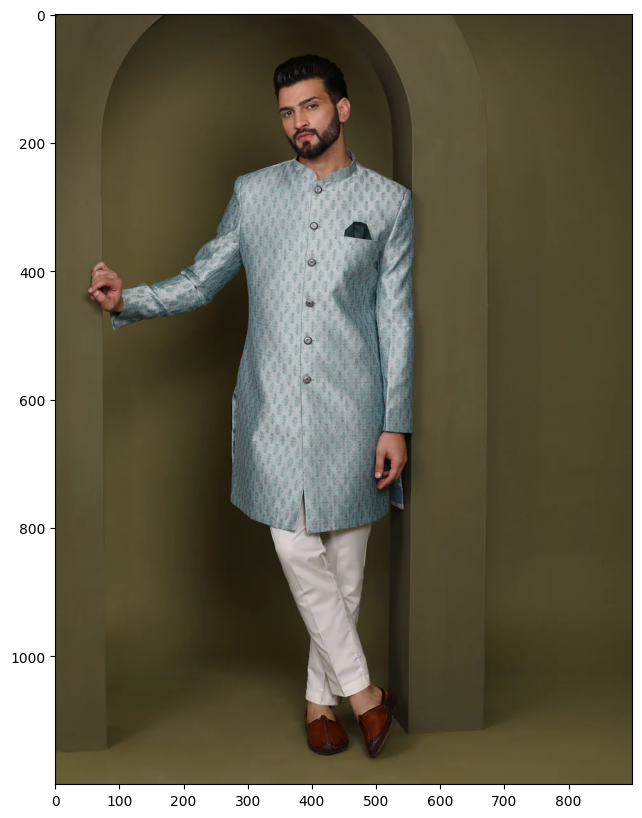

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "/content/sam_vit_h_4b8939.pth"
model_type = "vit_h"

if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    device = torch.device("cpu")


sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [ ]:
predictor.set_image(image)

To select the Dress, choose a point on it. Points are input to the model in (x,y) format and come with labels 1 (foreground point) or 0 (background point). Multiple points can be input; here we use only one. The chosen point will be shown as a star on the image.

In [ ]:
input_point = np.array([[400, 400]])
input_label = np.array([1])

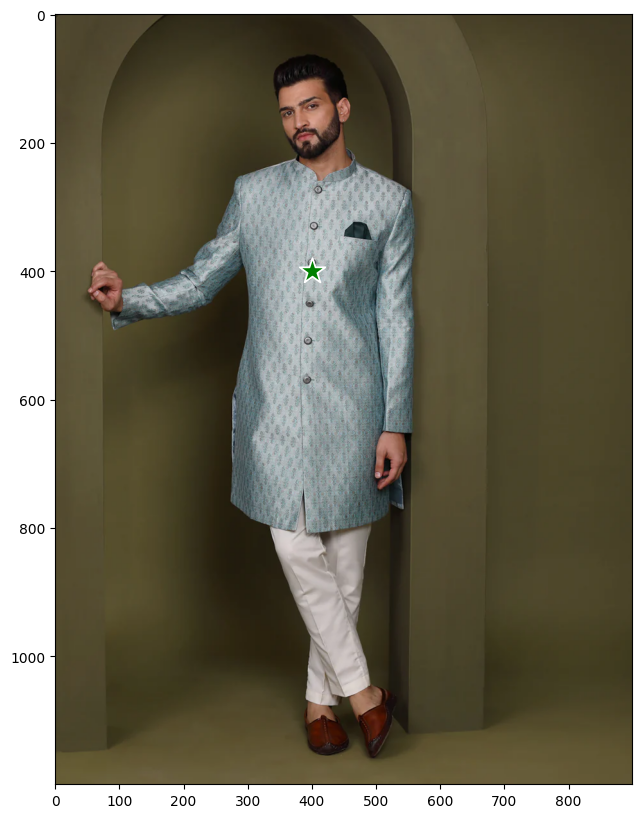

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

Predict with `SamPredictor.predict`. The model returns masks, quality predictions for those masks, and low resolution mask logits that can be passed to the next iteration of prediction.

In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

With `multimask_output=True` (the default setting), SAM outputs 3 masks, where `scores` gives the model's own estimation of the quality of these masks. This setting is intended for ambiguous input prompts, and helps the model disambiguate different objects consistent with the prompt. When `False`, it will return a single mask. For ambiguous prompts such as a single point, it is recommended to use `multimask_output=True` even if only a single mask is desired; the best single mask can be chosen by picking the one with the highest score returned in `scores`. This will often result in a better mask.

In [ ]:
masks.shape  # (number_of_masks) x H x W

(3, 1200, 900)

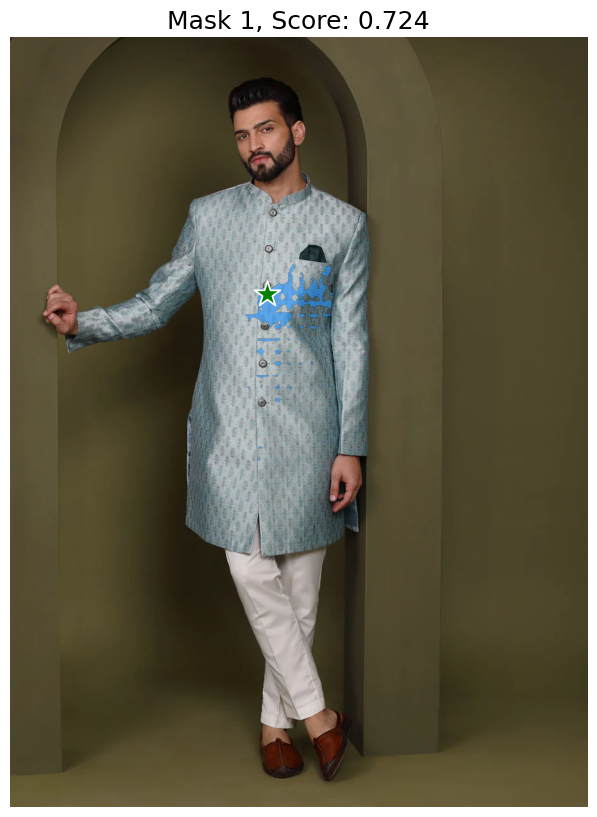

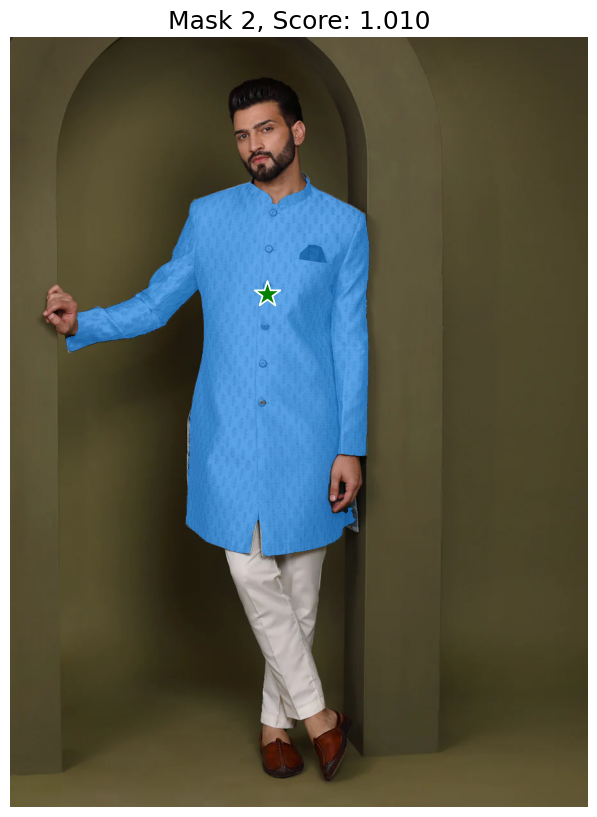

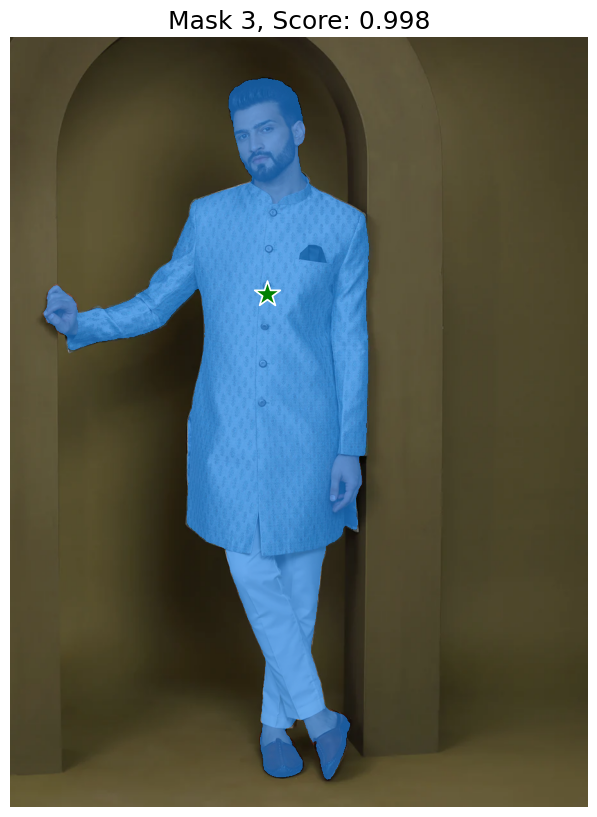

In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()


## Specifying a specific object with additional points

The single input point is ambiguous, and the model has returned multiple objects consistent with it. To obtain a single object, multiple points can be provided. If available, a mask from a previous iteration can also be supplied to the model to aid in prediction. When specifying a single object with multiple prompts, a single mask can be requested by setting `multimask_output=False`.

In [ ]:
input_point = np.array([[525, 600], [400, 400]])
input_label = np.array([1, 1])

mask_input = logits[np.argmax(scores), :, :]  # Choose the model's best mask

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

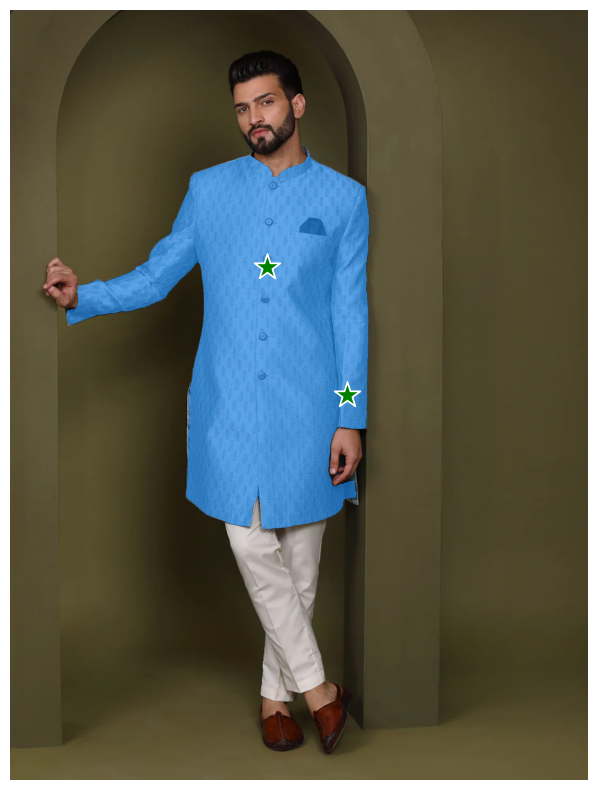

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

Given fabric cloth is reshaped to dimension of the given input image

## Fill the mask

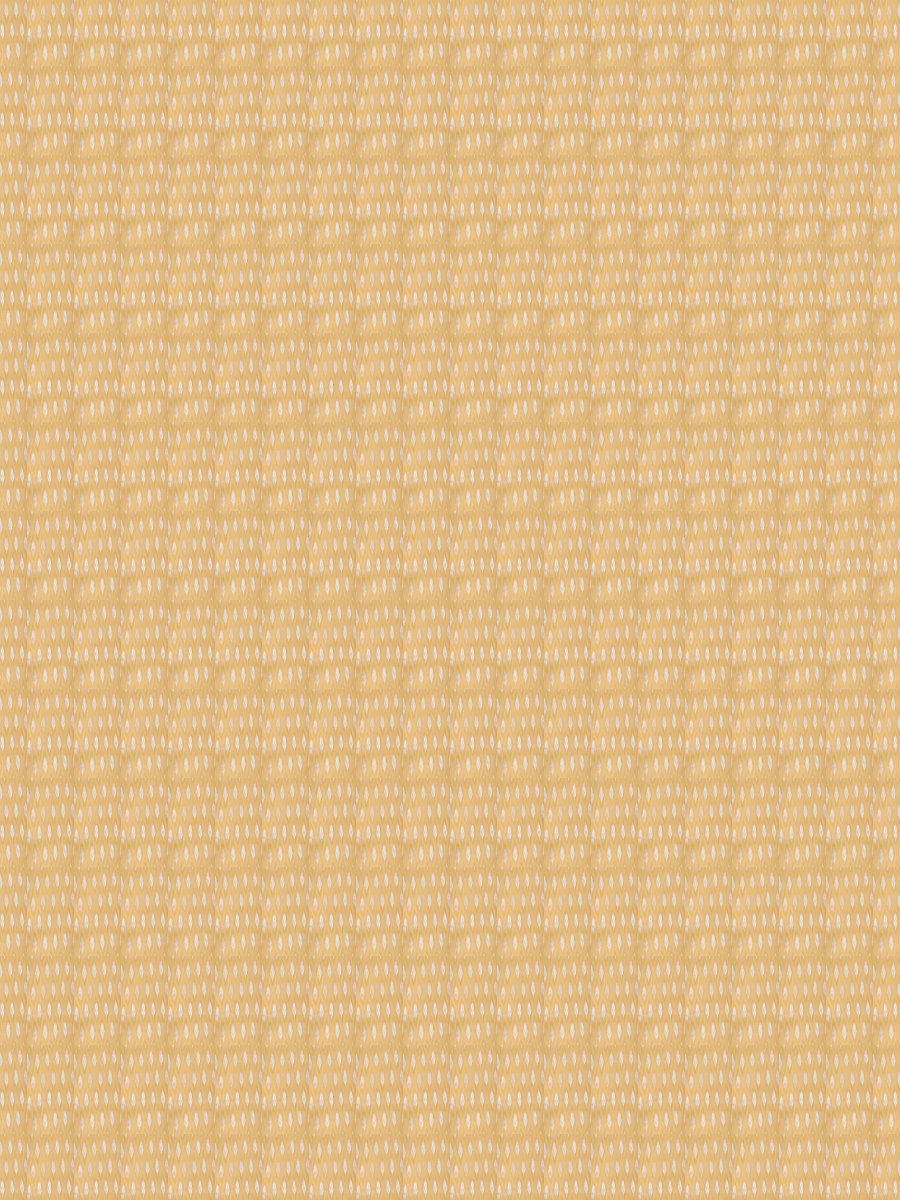

(1200, 900, 3)


In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
# Load the images

yellow_fabric_path = '/content/drive/MyDrive/KV/0.png'
yellow_fabric = cv2.imread(yellow_fabric_path)

yellow_fabric = cv2.resize(yellow_fabric, (47, 89))

# Construct the output image by stacking horizontally and vertically
n, m = (20, 14)
yellow_fabric = np.tile(yellow_fabric, (m, n, 1))

crop_x1, crop_x2 = 23, 1223  # Adjust these values based on your specific cropping needs
crop_y1, crop_y2 = 20, 920   # Adjust these values based on your specific cropping needs
yellow_fabric = yellow_fabric[ crop_x1:crop_x2,crop_y1:crop_y2]

# Display the original and cropped images

cv2_imshow(yellow_fabric)
print(yellow_fabric.shape)

In [ ]:


def show_final(mask,image,color,ax):
    mask = mask.reshape((1200,900,1))
    final_image = mask * color
    final_image = image - mask*image + final_image
    cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    return final_image
    #cv2_imshow(final_image)


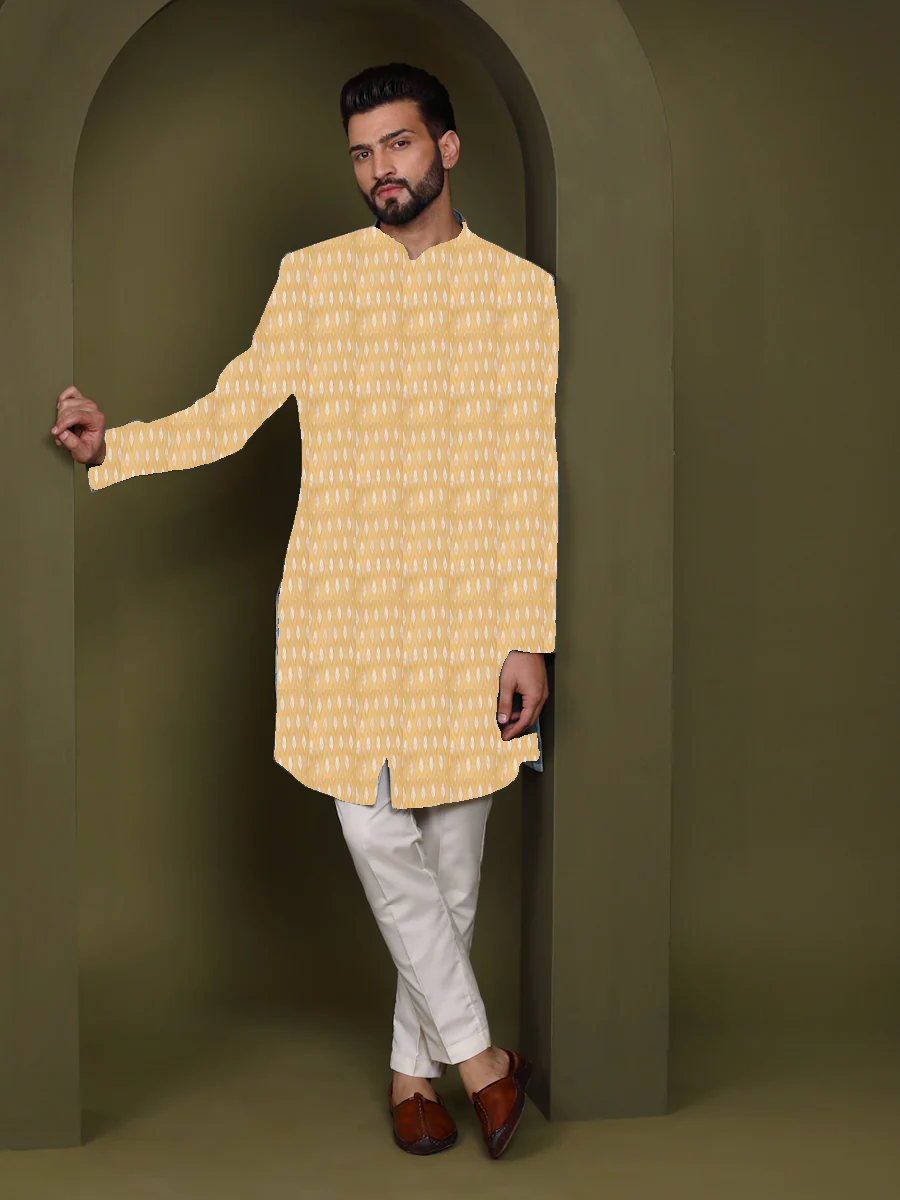

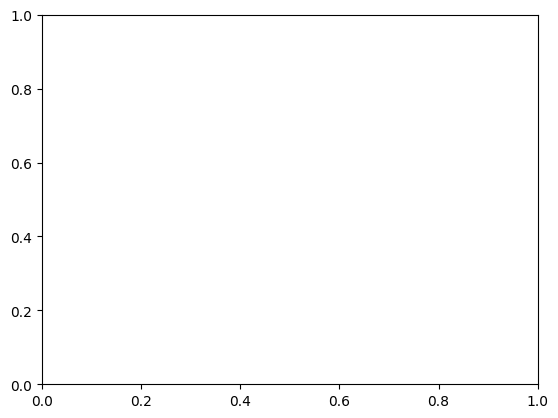

In [ ]:

#plt.imshow(image)
final_image = show_final(masks,blue_image,yellow_fabric, plt.gca())
cv2_imshow(final_image)



## Specifying a specific object with a box

The model can also take a box as input, provided in xyxy format.

In [ ]:
input_box = np.array([350,820,490,1080])

In [ ]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

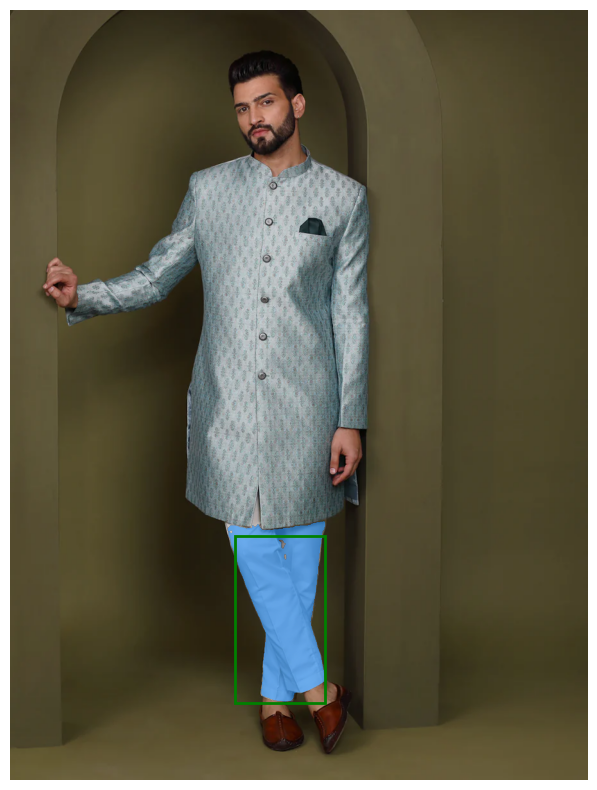

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

# Assignment 2

# TryonGAN:
TryonGAN a type of generative adversarial network (GAN) that was specifically created for fashion-related virtual try-on applications. The GAN consists of two neural networks, a discriminator and a generator, which are trained simultaneously in a competitive manner. This technology has been developed to ensure that users can try on clothes virtually before making a purchase, thereby reducing the likelihood of returns or dissatisfaction with products.
Generator: TryonGAN tool uses an advanced image generation technique to produce modified images of a human model wearing different outfits. This is done by taking an input image of the model without the intended apparel and generating a new image of the same model wearing the desired clothing.
Discriminator: Authenticity of generated images is evaluated by the discriminator, which distinguishes between genuine photographs and synthetic images created by the generator.

Training: In a generative adversarial network, objective of the generator is to create images that appear authentic to the discriminator, while the discriminator aims to distinguish between real and fake images. This competition between the two networks leads to a gradual improvement in the quality of the generated images over time.

# SDAFN (Spatial Detail Attention Fused Network):
SDAFN is a unique network architecture that has been developed to enhance the quality and details of virtual try-on results. Its main focus is to improve the spatial details of the generated images, particularly in the areas related to clothing items.

Spatial Detail Attention: SDAFN leverages attention mechanisms to highlight specific spatial details within the image. By identifying and emphasizing the most important regions associated with clothing, it ensures superior integration and intricate detailing of the attire in the synthesized images.

Fused Network: To generate more realistic and detailed virtual try-on results, SDAFN leverages a combination of specialized networks that cater to different aspects such as detail enhancement, spatial attention, and image synthesis.

#HR-VITON (High-Resolution Virtual Try-On Network):
HR-VITON is a unique model that has been specifically designed for virtual try-on applications. The model is capable of handling high-resolution images, which helps to achieve more detailed and realistic try-on results.

High-Resolution Handling: HR-VITON has been designed to work exceptionally well with high-resolution images, ensuring that the finer details of both the person and the clothing items are well-preserved. This results in generating more visually appealing and accurate try-on images, without any loss of image quality.

Integration of Vision Transformer (ViT): HR-VITON has the potential to incorporate the Vision Transformer architecture, renowned for its effectiveness in handling visual data by capturing both global and local features in an image. The integration of ViT could potentially enhance HR-VITON's ability to understand and synthesize clothing items on individuals in high-resolution images.
TryonDiffusion:
TryonDiffusion is a model that leverages diffusion models to enable virtual try-on applications. These models are probabilistic and work by iteratively transforming a noise source to produce highly realistic images.

#Diffusion Models:
One of the techniques used to create virtual try-on images is called TryonDiffusion. This technique gradually adds noise to an input image in a controlled manner, allowing the generation of images through a series of transformations. It is most likely used to synthesize virtual try-on images by iteratively modifying an initial image representation to create realistic clothing appearances on a person.

Probabilistic Generation: TryonDiffusion is capable of producing realistic and diverse try-on images while retaining complete control over the image generation process by using probabilistic modeling of diffusion.